In [1]:
import pandas as pd
import numpy as np
import os
import utils

In [2]:
#path = "./tctodd/"
path = "../../Desktop/MML Project/tctodd/"
dirs = os.listdir(path=path)
weeks = sorted([i for i in dirs if i != ".DS_Store"])
filenames = sorted(os.listdir(path+weeks[1]))

data = []
labels = dict()
label_cnt = 0

for w in weeks:
    temp_path = path+w+"/"
    filenames = sorted(os.listdir(temp_path))
    for fn in filenames:
        label = fn.split('.')[0][:-2]
        
        if label not in labels:
            labels[label] = label_cnt
            label_cnt += 1
            
        data.append({'label':labels[label], 'time_series':pd.read_csv(temp_path+fn, header=None, sep='\t',).values})
        

In [3]:
df = pd.DataFrame(data, columns=['label', 'time_series'])
print(df['label'].value_counts())
df.head()

93    27
68    27
50    27
52    27
54    27
      ..
35    27
37    27
39    27
41    27
0     27
Name: label, Length: 95, dtype: int64


,label,time_series
0,0,"[[-0.06490900000000001, 0.034318, -0.043963999..."
1,0,"[[-0.10705899999999999, -0.126109, -0.053742, ..."
2,0,"[[-0.061426999999999995, -0.082576, -0.1029910..."
3,1,"[[-0.128178, 0.02695, -0.050126, 0.455028, 0.4..."
4,1,"[[-0.143672, -0.14441600000000002, -0.047447, ..."


In [4]:
X = df['time_series']
y = df['label']
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from utils import *
seed = 0
n_coords = 60
X_interp = interpolate_data(X, n_coords)
X_interp = concatenate_examples(X_interp)


SC = StandardScaler()
SC.fit(X_interp)
X_interp = SC.transform(X_interp)
kpca = KernelPCA(n_components=None, kernel='linear')

principal_comps = kpca.fit_transform(X_interp)
explained_variance = np.var(principal_comps, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


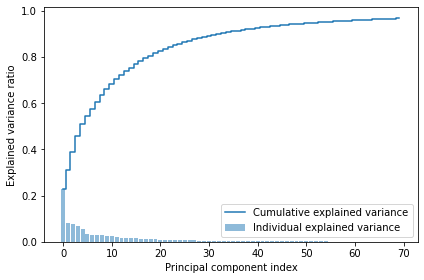

In [5]:
import matplotlib.pyplot as plt
cum_sum_eigenvalues = np.cumsum(explained_variance_ratio)
plt.bar(range(0,len(explained_variance_ratio[:70])), explained_variance_ratio[:70], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[:70])), cum_sum_eigenvalues[:70], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
print(f'first 55 dims {cum_sum_eigenvalues[54]} var explained')

first 55 dims 0.9512066945872513 var explained


In [4]:
import sklearn as sk
import itertools
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from utils import *
from tqdm import tqdm
seed = 0


X = df['time_series']
y = df['label']



n_pcs = 55
n_coords = 60
##LINEAR KERNEL
params = [['linear'], [0.0001, 0.0005, 0.001, 0.005, 0.01, 1]]
params_comb = list(itertools.product(*params))
##RBF KERNEL
params = [['rbf'], [0.0001, 0.0005, 0.001, 0.005, 0.01, 1], [0.001, 0.01, 1, 2, 5, 10]]
params_comb += list(itertools.product(*params))
##POLYNOMIAL KERNEL
params = [['poly'], [0.0001, 0.0005, 0.001, 0.005, 0.01, 1], [0.001, 0.01, 1, 2, 5, 10], [3, 6, 10, 15, 20, 25, 30], [0, 0.1, 0.5, 1, 5, 10]]
params_comb += list(itertools.product(*params))
best_comb = ''
best_acc = 0
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1, random_state=seed)
X_train_interp, X_test_interp = interpolate_data(X_train, n_coords), interpolate_data(X_test, n_coords)
X_train_interp = concatenate_examples(X_train_interp)
X_test_interp = concatenate_examples(X_test_interp)


SC = StandardScaler()
SC.fit(X_train_interp)
X_train_interp = SC.transform(X_train_interp)
X_test_interp = SC.transform(X_test_interp)

kpca = KernelPCA(n_components=None, kernel='linear')

principal_comps_train = kpca.fit_transform(X_train_interp)
principal_comps_test = kpca.transform(X_test_interp)
for params in tqdm(params_comb, desc='doing parameters search...'):
    if len(params) == 2:
        combination = tuple([params[0], params[1], 1, 3, 0])
    elif len(params) == 3:
        combination = tuple([params[0], params[1], params[2], 3, 0])
    else:
        combination = params
    svc = SVC(kernel=combination[0], C=combination[1], gamma=combination[2], degree=combination[3], coef0=combination[4], max_iter=1000)
    princ_components = principal_comps_train[:, :n_pcs]
    svc.fit(princ_components, y_train.values)
    test_princ_components = principal_comps_test[:, :n_pcs]
    predictions = svc.predict(test_princ_components)
    res = accuracy_score(y_test.values, predictions)
    if res > best_acc:
        best_acc = res
        best_comb = combination
        print(f'Found best combination! {best_comb} w. accuracy of {best_acc}.')

doing parameters search...:   0%|          | 1/1554 [00:00<20:14,  1.28it/s]

Found best combination! ('linear', 0.0001, 1, 3, 0) w. accuracy of 0.26459143968871596.


doing parameters search...:   0%|          | 2/1554 [00:01<18:57,  1.36it/s]

Found best combination! ('linear', 0.0005, 1, 3, 0) w. accuracy of 0.7821011673151751.


doing parameters search...:   0%|          | 3/1554 [00:02<18:14,  1.42it/s]

Found best combination! ('linear', 0.001, 1, 3, 0) w. accuracy of 0.8754863813229572.


doing parameters search...:   0%|          | 4/1554 [00:02<18:17,  1.41it/s]

Found best combination! ('linear', 0.005, 1, 3, 0) w. accuracy of 0.9377431906614786.


c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:   0%|          | 5/1554 [00:03<17:24,  1.48it/s]

Found best combination! ('linear', 0.01, 1, 3, 0) w. accuracy of 0.9416342412451362.


c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:   0%|          | 6/1554 [00:03<16:42,  1.54it/s]

Found best combination! ('linear', 1, 1, 3, 0) w. accuracy of 0.9455252918287937.


doing parameters search...:   3%|▎         | 54/1554 [01:03<18:38,  1.34it/s]

Found best combination! ('poly', 0.0001, 0.001, 6, 10) w. accuracy of 0.9494163424124513.


doing parameters search...:   5%|▍         | 72/1554 [01:20<24:33,  1.01it/s]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:   7%|▋         | 114/1554 [02:05<30:33,  1.27s/it]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:   7%|▋         | 115/1554 [02:07<30:17,  1.26s/it]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_i

Found best combination! ('poly', 1, 0.001, 3, 5) w. accuracy of 0.953307392996109.


doing parameters search...:  88%|████████▊ | 1374/1554 [16:04<03:29,  1.17s/it]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:  88%|████████▊ | 1375/1554 [16:05<03:31,  1.18s/it]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:  89%|████████▊ | 1376/1554 [16:06<03:29,  1.17s/it]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (m

In [5]:
print(best_acc, best_comb)

0.953307392996109 ('poly', 1, 0.001, 3, 5)


In [6]:
#for the best params combination il valore dell accuracy per 10Kfold
skf = sk.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
mean_accuracy = 0
n_princ_cs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
res_per_pc = np.zeros(len(n_princ_cs))
for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    X_train_interp, X_test_interp = interpolate_data(X_train, n_coords), interpolate_data(X_test, n_coords)
    X_train_interp = concatenate_examples(X_train_interp)
    X_test_interp = concatenate_examples(X_test_interp)
    SC = StandardScaler()
    SC.fit(X_train_interp)
    X_train_interp = SC.transform(X_train_interp)
    X_test_interp = SC.transform(X_test_interp)

    kpca = KernelPCA(n_components=None, kernel='linear')

    principal_comps_train = kpca.fit_transform(X_train_interp)
    principal_comps_test = kpca.transform(X_test_interp)
    svc = SVC(kernel=best_comb[0], C=best_comb[1], gamma=best_comb[2], degree=best_comb[3], coef0=best_comb[4])
    for i, n_pc in enumerate(n_princ_cs):
        princ_components = principal_comps_train[:, :n_pc]
        svc.fit(princ_components, y_train.values)
        test_princ_components = principal_comps_test[:, :n_pc]
        predictions = svc.predict(test_princ_components)
        res = accuracy_score(y_test.values, predictions)
        res_per_pc[i] += res
print(f'Reached an accuracy of {res_per_pc[-1]/10}.')
svc_res_per_pc = res_per_pc/10


Reached an accuracy of 0.9504939810311285.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
criterion = ['gini', 'entropy']
n_estimators = [10, 25, 50, 100, 200]
max_depth = [10, 20, 30, 50, 100]
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
params_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
}
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.1, seed=seed)
best_comb = ''
best_acc = 0
X_train_interp, X_test_interp = interpolate_data(X_train, n_coords), interpolate_data(X_test, n_coords)
X_train_interp = concatenate_examples(X_train_interp)
X_test_interp = concatenate_examples(X_test_interp)


SC = StandardScaler()
SC.fit(X_train_interp)
X_train_interp = SC.transform(X_train_interp)
X_test_interp = SC.transform(X_test_interp)

kpca = KernelPCA(n_components=None, kernel='linear')

principal_comps_train = kpca.fit_transform(X_train_interp)
principal_comps_test = kpca.transform(X_test_interp)
for params in list(ParameterGrid(params_grid)):
    
    rf = RandomForestClassifier(*params)
    princ_components = principal_comps_train[:, :n_pcs]
    rf.fit(princ_components, y_train.values)
    test_princ_components = principal_comps_test[:, :n_pcs]
    predictions = rf.predict(test_princ_components)
    res = accuracy_score(y_test.values, predictions)
    if res > best_acc:
        best_acc = res
        best_comb = params
        print(f'Found best combination! {best_comb} w. accuracy of {best_acc}.')
    



In [ ]:
#for the best params combination il valore dell accuracy per 10Kfold
skf = sk.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
n_princ_cs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
res_per_pc = np.zeros(len(n_princ_cs))
for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    X_train_interp, X_test_interp = interpolate_data(X_train, n_coords), interpolate_data(X_test, n_coords)
    X_train_interp = concatenate_examples(X_train_interp)
    X_test_interp = concatenate_examples(X_test_interp)
    SC = StandardScaler()
    SC.fit(X_train_interp)
    X_train_interp = SC.transform(X_train_interp)
    X_test_interp = SC.transform(X_test_interp)

    kpca = KernelPCA(n_components=None, kernel='linear')

    principal_comps_train = kpca.fit_transform(X_train_interp)
    principal_comps_test = kpca.transform(X_test_interp)
    rf = RandomForestClassifier(*best_comb)
    
    for i, n_pc in enumerate(n_princ_cs):
        princ_components = principal_comps_train[:, :n_pc]
        rf.fit(princ_components, y_train.values)
        test_princ_components = principal_comps_test[:, :n_pc]
        predictions = rf.predict(test_princ_components)
        res = accuracy_score(y_test.values, predictions)
        res_per_pc[i] += res

print(f'Reached an accuracy of {res_per_pc[-1]/10}.')
rf_res_per_pc = res_per_pc/10


In [ ]:
print('SVC accuracy x n principal components: ', svc_res_per_pc)
print('RF accuracy x n principal components: ', rf_res_per_pc)